In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy import fft
import random
import pywt.data
from PIL import Image
import pandas as pd
import seaborn as sns
import os
import pickle

In [2]:
# assign directory
ROOT_DIR = '/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/'
data_dir = ROOT_DIR + 'raw-data/agriVision/toy-agriVision-RGB-cleaned'
 
# iterate over files in that directory
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]
file_names = os.listdir(data_dir)
n = len(file_list)

In [3]:
def getIndexDF(image, no_zero =False):
    x_freqs = fft.fftfreq(image.shape[0])
    y_freqs = fft.fftfreq(image.shape[1])
    coord_df = pd.DataFrame()
    coord_df["index_coords"] = [(x,y) for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["x_index"] = [x for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["y_index"] = [y for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["x_freq"] = [x_freqs[x] for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["y_freq"] = [y_freqs[y] for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["magnitude"] = np.sqrt(coord_df["x_freq"] ** 2 + coord_df["y_freq"] **2)
    coord_df = coord_df.set_index(["index_coords"])
    coord_df = coord_df[(coord_df["x_freq"] >= 0 )& (coord_df["y_freq"] >= 0)]
    if no_zero:
        coord_df = coord_df[(coord_df["x_freq"] != 0 )| (coord_df["y_freq"] != 0)]
    return coord_df

In [4]:
def convert_fourier_list(folder_dir, c):
    file_list = [os.path.join(folder_dir, filename) for filename in os.listdir(folder_dir)]
    image = np.array(Image.open(file_list[0]).convert('L'))
    coord_df = getIndexDF(image, no_zero =False).sort_values(["magnitude"])
    x = coord_df["x_index"].to_numpy()
    y = coord_df["y_index"].to_numpy()
    magnitudes = coord_df["magnitude"]
    freq_arr = []
    mag_arr =  []
    freq_arr = [0]*len(file_list)
    mag_arr = [0]*len(file_list)
    for k in range(len(file_list)):
        if c >= 3:
            image = np.array(Image.open(file_list[k]).convert('L'))
        else:
            image = np.array(Image.open(file_list[k]))[:,:,c]
        transformed = np.array(fft.fft2(image))
        freq_arr[k] = transformed[tuple(x), tuple(y)]
        mag_arr[k] = magnitudes
    sample = np.concatenate(np.array(freq_arr).T)
    mag_flat = np.concatenate(np.array(mag_arr).T)
    return sample, mag_flat

In [5]:
def recursive_split(freqs, mags, threshold =0.05, max_depth = 5, presplit = 0):
    magnitude_splits = []
    def recursive_helper(freqs, mags, magnitude_splits, depth, presplit):
        if depth > 0 and mags[0] != mags[-1]:
            n = (mags[-1] + mags[0])/2
            idx = np.argmax(mags>n)
            if presplit > 0:
                stat = threshold + 1
            else:
                first_sample = np.concatenate([np.real(freqs[:idx]),np.imag(freqs[:idx])])
                second_sample = np.concatenate([np.real(freqs[idx:]),np.imag(freqs[idx:])])
                stat = stats.ks_2samp(first_sample, second_sample).statistic
            if stat > threshold:
                magnitude_splits.append(n)
                recursive_helper(freqs[:idx], mags[:idx], magnitude_splits, depth-1, max(presplit-1, 0))
                recursive_helper(freqs[idx:], mags[idx:], magnitude_splits, depth-1, max(presplit-1, 0))
        elif mags[0] == mags[-1]:
            print(f"Both Endpoints Are The Same {mags[0]} and {mags[-1]} Recursion Depth of {max_depth - depth}")
        elif depth == 0:
            print(f"Recursion Depth Exceeded Endpoints are {mags[0]} and {mags[-1]}")
    recursive_helper(freqs, mags, magnitude_splits, max_depth, presplit)
    return magnitude_splits





In [6]:
def convert_to_fourier_basis(folder_dir, color, threshold =0.05, max_depth = 5, presplit = 0, split_list = None):
    color_dict = {"Red":0, "Green":1, "Blue":2, "Gray":3, "Infrared": 4}
    c = color_dict[color]
    freqs, mags = convert_fourier_list(folder_dir, c)
    df = pd.DataFrame(columns=["band", "channel", "magnitude_endpoints","unique_magnitudes", "data"])

    if split_list == None:
        mag_splits = recursive_split(freqs, mags, threshold, max_depth, presplit)
    else:
        mag_splits = split_list
    
    sorted_mag_split = np.sort(mag_splits)
    print(sorted_mag_split)
    prev = 0
    for i in range(len(mag_splits)):
        next_idx = np.argmax(mags>=sorted_mag_split[i])
        next_freqs = np.concatenate([np.real(freqs[prev:next_idx]),np.imag(freqs[prev:next_idx])])
        num_mags = len(np.unique(mags[prev:next_idx]))
        mag_endpoints = (min(mags[prev:next_idx]), max(mags[prev:next_idx]))

        df.loc[len(df.index)] = [i+1, color, mag_endpoints, num_mags, next_freqs]
        prev = next_idx

    return df

In [11]:
red_converted = convert_to_fourier_basis(data_dir, "Red", threshold =0.02, max_depth = 9, presplit= 2)
red_converted["number_of_coefficents"] = red_converted["data"].apply(lambda x:len(x))/(2 *n)
red_converted

Both Endpoints Are The Same 0.0 and 0.0 Recursion Depth of 9
Both Endpoints Are The Same 0.001953125 and 0.001953125 Recursion Depth of 9
Both Endpoints Are The Same 0.0027621358640099515 and 0.0027621358640099515 Recursion Depth of 9
Recursion Depth Exceeded Endpoints are 0.00390625 and 0.004367320268554277
Recursion Depth Exceeded Endpoints are 0.005524271728019903 and 0.006176323555016366
Recursion Depth Exceeded Endpoints are 0.007042092334890604 and 0.0078125
Recursion Depth Exceeded Endpoints are 0.011048543456039806 and 0.01188039556698871
Recursion Depth Exceeded Endpoints are 0.012352647110032733 and 0.013101960805662831
[0.00097656 0.00218366 0.00356473 0.00525895 0.00666839 0.00802109
 0.0109183  0.01207525 0.01357721 0.01644257 0.02194551 0.02741871
 0.03299406 0.04398869 0.05497586 0.06602095 0.08802615 0.11006022
 0.13206901 0.15406518 0.17606856 0.19815606 0.22015294 0.24214621
 0.26415428 0.28614297 0.30814661 0.35217232 0.44020209 0.52825984]


,band,channel,magnitude_endpoints,unique_magnitudes,data,number_of_coefficents
0,1,Red,"(0.0, 0.0)",1,"[77928.0, 460483.0, 365878.0, 230599.0, 284593...",1.0
1,2,Red,"(0.001953125, 0.001953125)",1,"[-12974.592655331986, -45660.77029153175, -54....",2.0
2,3,Red,"(0.0027621358640099515, 0.0027621358640099515)",1,"[14184.106611974297, -18281.401770997843, 1045...",1.0
3,4,Red,"(0.00390625, 0.004367320268554277)",2,"[-3753.6335671811394, 4839.172219592722, -1538...",4.0
4,5,Red,"(0.005524271728019903, 0.006176323555016366)",3,"[2394.852349787814, 1147.5644067726053, 6912.6...",5.0
5,6,Red,"(0.007042092334890604, 0.0078125)",2,"[3043.671075303161, -9657.656023175681, -3985....",4.0
6,7,Red,"(0.008052940675034493, 0.010517900013934578)",6,"[-534.6031491594214, 2111.2590249634395, -997....",13.0
7,8,Red,"(0.011048543456039806, 0.01188039556698871)",4,"[-888.7412795504757, -2005.635692094722, 3037....",7.0
8,9,Red,"(0.012352647110032733, 0.013101960805662831)",3,"[-1509.9420581538498, 1127.5971491489754, -275...",6.0
9,10,Red,"(0.013671875, 0.016105881350068987)",9,"[162.45796669120477, 460.93597734919894, 7253....",21.0


In [12]:
red_converted = convert_to_fourier_basis(data_dir, "Red", threshold =0.02, max_depth = 9, presplit= 0)
red_converted["number_of_coefficents"] = red_converted["data"].apply(lambda x:len(x))/(2 *n)
red_converted

Both Endpoints Are The Same 0.0 and 0.0 Recursion Depth of 9
Both Endpoints Are The Same 0.001953125 and 0.001953125 Recursion Depth of 9
Both Endpoints Are The Same 0.0027621358640099515 and 0.0027621358640099515 Recursion Depth of 9
Recursion Depth Exceeded Endpoints are 0.00390625 and 0.004367320268554277
Recursion Depth Exceeded Endpoints are 0.005524271728019903 and 0.006176323555016366
Recursion Depth Exceeded Endpoints are 0.007042092334890604 and 0.0078125
Recursion Depth Exceeded Endpoints are 0.011048543456039806 and 0.01188039556698871
Recursion Depth Exceeded Endpoints are 0.012352647110032733 and 0.013101960805662831
[0.00097656 0.00218366 0.00356473 0.00525895 0.00666839 0.00802109
 0.0109183  0.01207525 0.01357721 0.01644257 0.02194551 0.02741871
 0.03299406 0.04398869 0.05497586 0.06602095 0.08802615 0.11006022
 0.13206901 0.15406518 0.17606856 0.19815606 0.22015294 0.24214621
 0.26415428 0.28614297 0.30814661 0.35217232 0.44020209 0.52825984]


,band,channel,magnitude_endpoints,unique_magnitudes,data,number_of_coefficents
0,1,Red,"(0.0, 0.0)",1,"[77928.0, 460483.0, 365878.0, 230599.0, 284593...",1.0
1,2,Red,"(0.001953125, 0.001953125)",1,"[-12974.592655331986, -45660.77029153175, -54....",2.0
2,3,Red,"(0.0027621358640099515, 0.0027621358640099515)",1,"[14184.106611974297, -18281.401770997843, 1045...",1.0
3,4,Red,"(0.00390625, 0.004367320268554277)",2,"[-3753.6335671811394, 4839.172219592722, -1538...",4.0
4,5,Red,"(0.005524271728019903, 0.006176323555016366)",3,"[2394.852349787814, 1147.5644067726053, 6912.6...",5.0
5,6,Red,"(0.007042092334890604, 0.0078125)",2,"[3043.671075303161, -9657.656023175681, -3985....",4.0
6,7,Red,"(0.008052940675034493, 0.010517900013934578)",6,"[-534.6031491594214, 2111.2590249634395, -997....",13.0
7,8,Red,"(0.011048543456039806, 0.01188039556698871)",4,"[-888.7412795504757, -2005.635692094722, 3037....",7.0
8,9,Red,"(0.012352647110032733, 0.013101960805662831)",3,"[-1509.9420581538498, 1127.5971491489754, -275...",6.0
9,10,Red,"(0.013671875, 0.016105881350068987)",9,"[162.45796669120477, 460.93597734919894, 7253....",21.0


In [13]:
red_converted = convert_to_fourier_basis(data_dir, "Red", threshold =0.03, max_depth = 9)
red_converted["number_of_coefficents"] = red_converted["data"].apply(lambda x:len(x))/(2 *n)
red_converted

Both Endpoints Are The Same 0.0 and 0.0 Recursion Depth of 9
Both Endpoints Are The Same 0.001953125 and 0.001953125 Recursion Depth of 9
Both Endpoints Are The Same 0.0027621358640099515 and 0.0027621358640099515 Recursion Depth of 9
Recursion Depth Exceeded Endpoints are 0.00390625 and 0.004367320268554277
Recursion Depth Exceeded Endpoints are 0.005524271728019903 and 0.006176323555016366
Recursion Depth Exceeded Endpoints are 0.007042092334890604 and 0.0078125
[0.00097656 0.00218366 0.00356473 0.00525895 0.00666839 0.00802109
 0.0109183  0.01644257 0.02194551 0.03299406 0.04398869 0.06602095
 0.08802615 0.13206901 0.17606856 0.22015294 0.26415428 0.30814661
 0.35217232 0.52825984]


,band,channel,magnitude_endpoints,unique_magnitudes,data,number_of_coefficents
0,1,Red,"(0.0, 0.0)",1,"[77928.0, 460483.0, 365878.0, 230599.0, 284593...",1.0
1,2,Red,"(0.001953125, 0.001953125)",1,"[-12974.592655331986, -45660.77029153175, -54....",2.0
2,3,Red,"(0.0027621358640099515, 0.0027621358640099515)",1,"[14184.106611974297, -18281.401770997843, 1045...",1.0
3,4,Red,"(0.00390625, 0.004367320268554277)",2,"[-3753.6335671811394, 4839.172219592722, -1538...",4.0
4,5,Red,"(0.005524271728019903, 0.006176323555016366)",3,"[2394.852349787814, 1147.5644067726053, 6912.6...",5.0
5,6,Red,"(0.007042092334890604, 0.0078125)",2,"[3043.671075303161, -9657.656023175681, -3985....",4.0
6,7,Red,"(0.008052940675034493, 0.010517900013934578)",6,"[-534.6031491594214, 2111.2590249634395, -997....",13.0
7,8,Red,"(0.011048543456039806, 0.016105881350068987)",16,"[-888.7412795504757, -2005.635692094722, 3037....",34.0
8,9,Red,"(0.016572815184059706, 0.021836601342771385)",22,"[-322.77002216586715, -4455.769937760134, 868....",48.0
9,10,Red,"(0.02209708691207961, 0.03274034104343791)",53,"[103.10197120007294, -1145.0518648370926, 8918...",126.0


 
0.304 x - 6.526


1.355321078255036

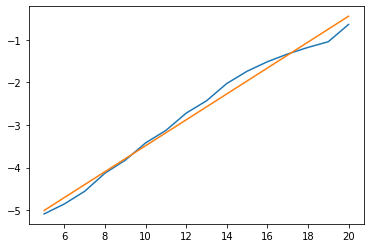

In [14]:
red_converted["magnitude_length"] = red_converted["magnitude_endpoints"].apply(lambda x: x[1] - x[0])
x = np.asfarray(red_converted["band"][4:].to_numpy())
y = np.asfarray(red_converted["magnitude_endpoints"].apply(lambda x: x[1])[4:].to_numpy())
logy = np.log(y)
plt.plot(x, logy)
print(np.poly1d(np.polyfit(x, logy, 1)))
plt.plot(x, np.poly1d(np.polyfit(x, logy, 1))(x))
np.exp(np.polyfit(x, logy, 1)[0])

In [15]:
green_converted = convert_to_fourier_basis(data_dir, "Green", threshold =0.03, max_depth = 9)
green_converted["number_of_coefficents"] = green_converted["data"].apply(lambda x:len(x))/(2 *n)
green_converted

Both Endpoints Are The Same 0.0 and 0.0 Recursion Depth of 9
Both Endpoints Are The Same 0.001953125 and 0.001953125 Recursion Depth of 9
Recursion Depth Exceeded Endpoints are 0.005524271728019903 and 0.006176323555016366
Recursion Depth Exceeded Endpoints are 0.007042092334890604 and 0.0078125
[0.00097656 0.00218366 0.00525895 0.00666839 0.00802109 0.0109183
 0.01644257 0.02194551 0.03299406 0.04398869 0.06602095 0.08802615
 0.13206901 0.17606856 0.22015294 0.26415428 0.30814661 0.35217232
 0.52825984]


,band,channel,magnitude_endpoints,unique_magnitudes,data,number_of_coefficents
0,1,Green,"(0.0, 0.0)",1,"[81813.0, 467467.0, 225750.0, 233632.0, 471000...",1.0
1,2,Green,"(0.001953125, 0.001953125)",1,"[-13671.295894683972, -45580.36262422351, -613...",2.0
2,3,Green,"(0.0027621358640099515, 0.004367320268554277)",3,"[14860.693507059621, -19230.850383875142, 6691...",5.0
3,4,Green,"(0.005524271728019903, 0.006176323555016366)",3,"[1679.8198230852297, 2231.5487585676647, 3101....",5.0
4,5,Green,"(0.007042092334890604, 0.0078125)",2,"[3507.8730613901016, -12302.990971247702, -672...",4.0
5,6,Green,"(0.008052940675034493, 0.010517900013934578)",6,"[-667.9157639064135, 2428.1412724772617, -804....",13.0
6,7,Green,"(0.011048543456039806, 0.016105881350068987)",16,"[-407.11342573213653, -2893.7565435238716, -91...",34.0
7,8,Green,"(0.016572815184059706, 0.021836601342771385)",22,"[-469.79202908560893, -4379.650245812762, -358...",48.0
8,9,Green,"(0.02209708691207961, 0.03274034104343791)",53,"[-66.7249692195249, -609.1047149455238, 3210.8...",126.0
9,10,Green,"(0.03314563036811941, 0.043891025496570764)",72,"[-995.4688037614753, 1811.3615872326213, -891....",184.0


 
0.3017 x - 6.189


1.3521781886796962

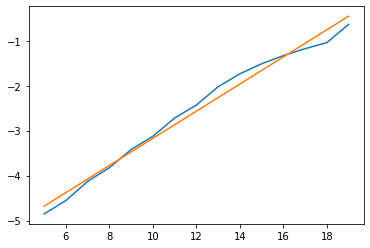

In [16]:
green_converted["magnitude_length"] = green_converted["magnitude_endpoints"].apply(lambda x: x[1] - x[0])
x = np.asfarray(green_converted["band"][4:].to_numpy())
y = np.asfarray(green_converted["magnitude_endpoints"].apply(lambda x: x[1])[4:].to_numpy())
logy = np.log(y)
plt.plot(x, logy)
print(np.poly1d(np.polyfit(x, logy, 1)))
plt.plot(x, np.poly1d(np.polyfit(x, logy, 1))(x))
np.exp(np.polyfit(x, logy, 1)[0])

In [17]:
blue_converted = convert_to_fourier_basis(data_dir, "Blue", threshold =0.03, max_depth = 9)
blue_converted["number_of_coefficents"] = blue_converted["data"].apply(lambda x:len(x))/(2 *n)
blue_converted

Both Endpoints Are The Same 0.0 and 0.0 Recursion Depth of 9
Both Endpoints Are The Same 0.001953125 and 0.001953125 Recursion Depth of 9
Both Endpoints Are The Same 0.0027621358640099515 and 0.0027621358640099515 Recursion Depth of 9
Recursion Depth Exceeded Endpoints are 0.00390625 and 0.004367320268554277
Recursion Depth Exceeded Endpoints are 0.005524271728019903 and 0.006176323555016366
Recursion Depth Exceeded Endpoints are 0.007042092334890604 and 0.0078125
[0.00097656 0.00218366 0.00356473 0.00525895 0.00666839 0.00802109
 0.0109183  0.01644257 0.02194551 0.03299406 0.04398869 0.06602095
 0.08802615 0.11006022 0.13206901 0.15406518 0.17606856 0.22015294
 0.26415428 0.30814661 0.35217232 0.44020209 0.52825984]


,band,channel,magnitude_endpoints,unique_magnitudes,data,number_of_coefficents
0,1,Blue,"(0.0, 0.0)",1,"[97520.0, 462386.0, 242847.0, 232402.0, 545272...",1.0
1,2,Blue,"(0.001953125, 0.001953125)",1,"[-17819.004968585505, -44886.37086057498, 8550...",2.0
2,3,Blue,"(0.0027621358640099515, 0.0027621358640099515)",1,"[17089.589957157372, -18661.971255577926, 2459...",1.0
3,4,Blue,"(0.00390625, 0.004367320268554277)",2,"[-5753.920789943681, 4957.739356623711, -10232...",4.0
4,5,Blue,"(0.005524271728019903, 0.006176323555016366)",3,"[-2890.776799271239, 2008.4722622731708, 4178....",5.0
5,6,Blue,"(0.007042092334890604, 0.0078125)",2,"[5940.579280067113, -11184.59867101445, 871.53...",4.0
6,7,Blue,"(0.008052940675034493, 0.010517900013934578)",6,"[3090.289989974526, 2403.0111444213394, 2139.3...",13.0
7,8,Blue,"(0.011048543456039806, 0.016105881350068987)",16,"[890.9303517748317, -2177.084315505193, 1404.6...",34.0
8,9,Blue,"(0.016572815184059706, 0.021836601342771385)",22,"[-652.6257027819677, -4610.299630287783, 3120....",48.0
9,10,Blue,"(0.02209708691207961, 0.03274034104343791)",53,"[-459.58992724394307, -975.1328161037195, 1781...",126.0


 
0.2473 x - 6.015


1.2805036964439493

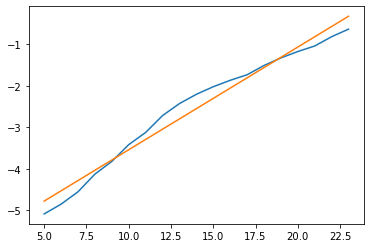

In [18]:
blue_converted["magnitude_length"] = blue_converted["magnitude_endpoints"].apply(lambda x: x[1] - x[0])
x = np.asfarray(blue_converted["band"][4:].to_numpy())
y = np.asfarray(blue_converted["magnitude_endpoints"].apply(lambda x: x[1])[4:].to_numpy())
logy = np.log(y)
plt.plot(x, logy)
print(np.poly1d(np.polyfit(x, logy, 1)))
plt.plot(x, np.poly1d(np.polyfit(x, logy, 1))(x))
np.exp(np.polyfit(x, logy, 1)[0])

In [19]:
gray_converted = convert_to_fourier_basis(data_dir, "Gray", threshold =0.03, max_depth = 9)
gray_converted["number_of_coefficents"] = gray_converted["data"].apply(lambda x:len(x))/(2 *n)
gray_converted

Both Endpoints Are The Same 0.0 and 0.0 Recursion Depth of 9
Both Endpoints Are The Same 0.001953125 and 0.001953125 Recursion Depth of 9
Both Endpoints Are The Same 0.0027621358640099515 and 0.0027621358640099515 Recursion Depth of 9
Recursion Depth Exceeded Endpoints are 0.00390625 and 0.004367320268554277
Recursion Depth Exceeded Endpoints are 0.005524271728019903 and 0.006176323555016366
Recursion Depth Exceeded Endpoints are 0.007042092334890604 and 0.0078125
[0.00097656 0.00218366 0.00356473 0.00525895 0.00666839 0.00802109
 0.0109183  0.01644257 0.02194551 0.03299406 0.04398869 0.06602095
 0.08802615 0.13206901 0.17606856 0.22015294 0.26415428 0.30814661
 0.35217232 0.52825984]


,band,channel,magnitude_endpoints,unique_magnitudes,data,number_of_coefficents
0,1,Gray,"(0.0, 0.0)",1,"[80367.0, 464026.0, 265558.0, 232272.0, 394565...",1.0
1,2,Gray,"(0.001953125, 0.001953125)",1,"[-13430.048826277703, -45607.0841630378, -2872...",2.0
2,3,Gray,"(0.0027621358640099515, 0.0027621358640099515)",1,"[14616.780183878062, -18736.24359816748, 7430....",1.0
3,4,Gray,"(0.00390625, 0.004367320268554277)",2,"[-3917.8621116558706, 5112.687988541338, -8154...",4.0
4,5,Gray,"(0.005524271728019903, 0.006176323555016366)",3,"[1987.4616521549997, 1684.7761794782002, 4358....",5.0
5,6,Gray,"(0.007042092334890604, 0.0078125)",2,"[3304.957538574853, -10989.061833111191, -1184...",4.0
6,7,Gray,"(0.008052940675034493, 0.010517900013934578)",6,"[-671.8820488918707, 2292.7830400318353, -270....",13.0
7,8,Gray,"(0.011048543456039806, 0.016105881350068987)",16,"[-596.3965045249346, -2458.981803649216, 759.5...",34.0
8,9,Gray,"(0.016572815184059706, 0.021836601342771385)",22,"[-452.29783604268306, -4407.522572694999, 691....",48.0
9,10,Gray,"(0.02209708691207961, 0.03274034104343791)",53,"[13.158330891475558, -900.1066326574236, 4647....",126.0


 
0.304 x - 6.526


1.355321078255036

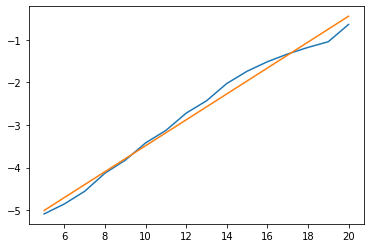

In [20]:
gray_converted["magnitude_length"] = gray_converted["magnitude_endpoints"].apply(lambda x: x[1] - x[0])
x = np.asfarray(gray_converted["band"][4:].to_numpy())
y = np.asfarray(gray_converted["magnitude_endpoints"].apply(lambda x: x[1])[4:].to_numpy())
logy = np.log(y)
plt.plot(x, logy)
print(np.poly1d(np.polyfit(x, logy, 1)))
plt.plot(x, np.poly1d(np.polyfit(x, logy, 1))(x))
np.exp(np.polyfit(x, logy, 1)[0])

In [21]:
infra_dir = ROOT_DIR + 'raw-data/agriVision/toy-agriVision-nearIR'

In [22]:
infra_converted = convert_to_fourier_basis(data_dir, "Infrared", threshold =0.03, max_depth = 9)
infra_converted["number_of_Coefficents"] = infra_converted["data"].apply(lambda x:len(x))/(2 *n)
infra_converted

Both Endpoints Are The Same 0.0 and 0.0 Recursion Depth of 9
Both Endpoints Are The Same 0.001953125 and 0.001953125 Recursion Depth of 9
Both Endpoints Are The Same 0.0027621358640099515 and 0.0027621358640099515 Recursion Depth of 9
Recursion Depth Exceeded Endpoints are 0.00390625 and 0.004367320268554277
Recursion Depth Exceeded Endpoints are 0.005524271728019903 and 0.006176323555016366
Recursion Depth Exceeded Endpoints are 0.007042092334890604 and 0.0078125
[0.00097656 0.00218366 0.00356473 0.00525895 0.00666839 0.00802109
 0.0109183  0.01644257 0.02194551 0.03299406 0.04398869 0.06602095
 0.08802615 0.13206901 0.17606856 0.22015294 0.26415428 0.30814661
 0.35217232 0.52825984]


,band,channel,magnitude_endpoints,unique_magnitudes,data,number_of_Coefficents
0,1,Infrared,"(0.0, 0.0)",1,"[80367.0, 464026.0, 265558.0, 232272.0, 394565...",1.0
1,2,Infrared,"(0.001953125, 0.001953125)",1,"[-13430.048826277703, -45607.0841630378, -2872...",2.0
2,3,Infrared,"(0.0027621358640099515, 0.0027621358640099515)",1,"[14616.780183878062, -18736.24359816748, 7430....",1.0
3,4,Infrared,"(0.00390625, 0.004367320268554277)",2,"[-3917.8621116558706, 5112.687988541338, -8154...",4.0
4,5,Infrared,"(0.005524271728019903, 0.006176323555016366)",3,"[1987.4616521549997, 1684.7761794782002, 4358....",5.0
5,6,Infrared,"(0.007042092334890604, 0.0078125)",2,"[3304.957538574853, -10989.061833111191, -1184...",4.0
6,7,Infrared,"(0.008052940675034493, 0.010517900013934578)",6,"[-671.8820488918707, 2292.7830400318353, -270....",13.0
7,8,Infrared,"(0.011048543456039806, 0.016105881350068987)",16,"[-596.3965045249346, -2458.981803649216, 759.5...",34.0
8,9,Infrared,"(0.016572815184059706, 0.021836601342771385)",22,"[-452.29783604268306, -4407.522572694999, 691....",48.0
9,10,Infrared,"(0.02209708691207961, 0.03274034104343791)",53,"[13.158330891475558, -900.1066326574236, 4647....",126.0


 
0.304 x - 6.526


1.355321078255036

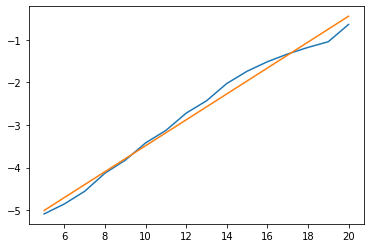

In [23]:
infra_converted["magnitude_length"] = infra_converted["magnitude_endpoints"].apply(lambda x: x[1] - x[0])
x = np.asfarray(infra_converted["band"][4:].to_numpy())
y = np.asfarray(infra_converted["magnitude_endpoints"].apply(lambda x: x[1])[4:].to_numpy())
logy = np.log(y)
plt.plot(x, logy)
print(np.poly1d(np.polyfit(x, logy, 1)))
plt.plot(x, np.poly1d(np.polyfit(x, logy, 1))(x))
np.exp(np.polyfit(x, logy, 1)[0])

# Unique Magnitude

In [43]:
def uniqueMags(folder_dir, start = None, end = None):
    file_list = [os.path.join(folder_dir, filename) for filename in os.listdir(folder_dir)]
    image = np.array(Image.open(file_list[0]).convert('L'))
    coord_df = getIndexDF(image, no_zero =False).sort_values(["magnitude"])
    magnitudes = np.unique(coord_df["magnitude"])
    if start != None:
        start_idx = np.argmax(magnitudes >= start)
        magnitudes = magnitudes[start_idx:]
    if end != None:
        end_idx = np.argmax(magnitudes > end)
        magnitudes = magnitudes[:end_idx]
    return magnitudes.tolist()


In [44]:
unique_splits = uniqueMags(data_dir,0, 0.008052940675034493 )[1:]
unique_splits

[0.001953125,
 0.0027621358640099515,
 0.00390625,
 0.004367320268554277,
 0.005524271728019903,
 0.005859375,
 0.006176323555016366,
 0.007042092334890604,
 0.0078125,
 0.008052940675034493]

# New Dataset Stuff

In [46]:
def getSplits(minfreq, maxfreq, mult):
    arr = []
    next_freq = minfreq
    while next_freq < maxfreq:
        arr.append(next_freq)
        next_freq *= mult
    return arr
splits = getSplits(0.008052940675034493,0.5282291467669505, 1.35)
splits
    


[0.008052940675034493,
 0.010871469911296566,
 0.014676484380250364,
 0.01981325391333799,
 0.02674789278300629,
 0.0361096552570585,
 0.04874803459702898,
 0.06580984670598912,
 0.08884329305308532,
 0.11993844562166518,
 0.161916901589248,
 0.21858781714548484,
 0.29509355314640456,
 0.3983762967476462]

In [47]:
full_data_dir = ROOT_DIR + 'raw-data/agriVision/toy-agriVision-RGB-cleaned'

In [48]:
full_red_converted = convert_to_fourier_basis(full_data_dir, "Red", split_list = splits)
full_red_converted

[0.00805294 0.01087147 0.01467648 0.01981325 0.02674789 0.03610966
 0.04874803 0.06580985 0.08884329 0.11993845 0.1619169  0.21858782
 0.29509355 0.3983763 ]


,band,channel,magnitude_endpoints,unique_magnitudes,data
0,1,Red,"(0.0, 0.0078125)",10,"[77928.0, 460483.0, 365878.0, 230599.0, 284593..."
1,2,Red,"(0.008052940675034493, 0.010517900013934578)",6,"[-534.6031491594214, 2111.2590249634395, -997...."
2,3,Red,"(0.011048543456039806, 0.014218964627501012)",11,"[-888.7412795504757, -2005.635692094722, 3037...."
3,4,Red,"(0.014874556847390447, 0.019628663322501738)",18,"[-1736.1929650677762, -2478.6695887130177, 116..."
4,5,Red,"(0.019918044974971814, 0.026565372087373914)",30,"[-1930.4699735281713, -282.08478551528356, -13..."
5,6,Red,"(0.02713367966689415, 0.03601384553630034)",52,"[-1037.28575165152, -8557.760104485591, 4746.8..."
6,7,Red,"(0.03633022507370757, 0.0485146185483368)",88,"[-1244.775644562143, -257.7212212131706, 14.04..."
7,8,Red,"(0.048828125, 0.0656552199764516)",156,"[-64.20682200582141, 500.7318876143078, -1701...."
8,9,Red,"(0.06588721794309765, 0.08884035480893875)",270,"[196.92286065104884, 359.5410812661388, -652.1..."
9,10,Red,"(0.08894763700574766, 0.11992251119538087)",472,"[976.888124226941, -734.1348941412823, 1119.00..."


In [49]:
early_red_converted = convert_to_fourier_basis(full_data_dir, "Red", split_list = unique_splits)
early_red_converted

[0.00195312 0.00276214 0.00390625 0.00436732 0.00552427 0.00585938
 0.00617632 0.00704209 0.0078125  0.00805294]


,band,channel,magnitude_endpoints,unique_magnitudes,data
0,1,Red,"(0.0, 0.0)",1,"[77928.0, 460483.0, 365878.0, 230599.0, 284593..."
1,2,Red,"(0.001953125, 0.001953125)",1,"[-12974.592655331986, -45660.77029153175, -54...."
2,3,Red,"(0.0027621358640099515, 0.0027621358640099515)",1,"[14184.106611974297, -18281.401770997843, 1045..."
3,4,Red,"(0.00390625, 0.00390625)",1,"[-3753.6335671811394, 4839.172219592722, -1538..."
4,5,Red,"(0.004367320268554277, 0.004367320268554277)",1,"[3453.2557775376813, -63473.40779840535, 12610..."
5,6,Red,"(0.005524271728019903, 0.005524271728019903)",1,"[2394.852349787814, 1147.5644067726053, 6912.6..."
6,7,Red,"(0.005859375, 0.005859375)",1,"[-1018.4646545106084, 2999.3281849347086, -180..."
7,8,Red,"(0.006176323555016366, 0.006176323555016366)",1,"[10123.195980052998, 792.7182814522566, 1234.1..."
8,9,Red,"(0.007042092334890604, 0.007042092334890604)",1,"[3043.671075303161, -9657.656023175681, -3985...."
9,10,Red,"(0.0078125, 0.0078125)",1,"[-1505.2892543579144, 4481.048551160074, 6207...."


In [50]:
full_green_converted = convert_to_fourier_basis(full_data_dir, "Green", split_list = splits)
full_green_converted

[0.00805294 0.01087147 0.01467648 0.01981325 0.02674789 0.03610966
 0.04874803 0.06580985 0.08884329 0.11993845 0.1619169  0.21858782
 0.29509355 0.3983763 ]


,band,channel,magnitude_endpoints,unique_magnitudes,data
0,1,Green,"(0.0, 0.0078125)",10,"[81813.0, 467467.0, 225750.0, 233632.0, 471000..."
1,2,Green,"(0.008052940675034493, 0.010517900013934578)",6,"[-667.9157639064135, 2428.1412724772617, -804...."
2,3,Green,"(0.011048543456039806, 0.014218964627501012)",11,"[-407.11342573213653, -2893.7565435238716, -91..."
3,4,Green,"(0.014874556847390447, 0.019628663322501738)",18,"[-1927.641998561064, -2252.719116308643, 913.6..."
4,5,Green,"(0.019918044974971814, 0.026565372087373914)",30,"[-1528.412988984921, 970.1548344899536, 492.94..."
5,6,Green,"(0.02713367966689415, 0.03601384553630034)",52,"[-926.4517399277479, -8823.998595429175, 2287...."
6,7,Green,"(0.03633022507370757, 0.0485146185483368)",88,"[-871.2568096388904, -206.07759826128267, -75...."
7,8,Green,"(0.048828125, 0.0656552199764516)",156,"[284.48033844809925, 152.3828690072395, -881.8..."
8,9,Green,"(0.06588721794309765, 0.08884035480893875)",270,"[414.8509016061579, 48.49962419247906, 91.4285..."
9,10,Green,"(0.08894763700574766, 0.11992251119538087)",472,"[861.307880858388, -724.6228642400943, 115.313..."


In [51]:
full_blue_converted = convert_to_fourier_basis(full_data_dir, "Blue", split_list = splits)
full_red_converted

[0.00805294 0.01087147 0.01467648 0.01981325 0.02674789 0.03610966
 0.04874803 0.06580985 0.08884329 0.11993845 0.1619169  0.21858782
 0.29509355 0.3983763 ]


,band,channel,magnitude_endpoints,unique_magnitudes,data
0,1,Red,"(0.0, 0.0078125)",10,"[77928.0, 460483.0, 365878.0, 230599.0, 284593..."
1,2,Red,"(0.008052940675034493, 0.010517900013934578)",6,"[-534.6031491594214, 2111.2590249634395, -997...."
2,3,Red,"(0.011048543456039806, 0.014218964627501012)",11,"[-888.7412795504757, -2005.635692094722, 3037...."
3,4,Red,"(0.014874556847390447, 0.019628663322501738)",18,"[-1736.1929650677762, -2478.6695887130177, 116..."
4,5,Red,"(0.019918044974971814, 0.026565372087373914)",30,"[-1930.4699735281713, -282.08478551528356, -13..."
5,6,Red,"(0.02713367966689415, 0.03601384553630034)",52,"[-1037.28575165152, -8557.760104485591, 4746.8..."
6,7,Red,"(0.03633022507370757, 0.0485146185483368)",88,"[-1244.775644562143, -257.7212212131706, 14.04..."
7,8,Red,"(0.048828125, 0.0656552199764516)",156,"[-64.20682200582141, 500.7318876143078, -1701...."
8,9,Red,"(0.06588721794309765, 0.08884035480893875)",270,"[196.92286065104884, 359.5410812661388, -652.1..."
9,10,Red,"(0.08894763700574766, 0.11992251119538087)",472,"[976.888124226941, -734.1348941412823, 1119.00..."


In [52]:
full_gray_converted = convert_to_fourier_basis(full_data_dir, "Gray", split_list = splits)
full_gray_converted

[0.00805294 0.01087147 0.01467648 0.01981325 0.02674789 0.03610966
 0.04874803 0.06580985 0.08884329 0.11993845 0.1619169  0.21858782
 0.29509355 0.3983763 ]


,band,channel,magnitude_endpoints,unique_magnitudes,data
0,1,Gray,"(0.0, 0.0078125)",10,"[80367.0, 464026.0, 265558.0, 232272.0, 394565..."
1,2,Gray,"(0.008052940675034493, 0.010517900013934578)",6,"[-671.8820488918707, 2292.7830400318353, -270...."
2,3,Gray,"(0.011048543456039806, 0.014218964627501012)",11,"[-596.3965045249346, -2458.981803649216, 759.5..."
3,4,Gray,"(0.014874556847390447, 0.019628663322501738)",18,"[-1869.7239977786285, -2382.1295181624646, 108..."
4,5,Gray,"(0.019918044974971814, 0.026565372087373914)",30,"[-1665.8794472636714, 359.6725136568671, -538...."
5,6,Gray,"(0.02713367966689415, 0.03601384553630034)",52,"[-966.1612670140148, -8676.588232700198, 3284...."
6,7,Gray,"(0.03633022507370757, 0.0485146185483368)",88,"[-1034.3708042519827, -224.3524918388693, -650..."
7,8,Gray,"(0.048828125, 0.0656552199764516)",156,"[131.72490764903847, 308.0491083390491, -1879...."
8,9,Gray,"(0.06588721794309765, 0.08884035480893875)",270,"[290.05000967250567, 202.0680681688911, -312.2..."
9,10,Gray,"(0.08894763700574766, 0.11992251119538087)",472,"[922.4654248203358, -727.132662832003, 439.060..."


In [53]:
full_infra_converted = convert_to_fourier_basis(full_data_dir, "Infrared", split_list = splits)
full_infra_converted

[0.00805294 0.01087147 0.01467648 0.01981325 0.02674789 0.03610966
 0.04874803 0.06580985 0.08884329 0.11993845 0.1619169  0.21858782
 0.29509355 0.3983763 ]


,band,channel,magnitude_endpoints,unique_magnitudes,data
0,1,Infrared,"(0.0, 0.0078125)",10,"[80367.0, 464026.0, 265558.0, 232272.0, 394565..."
1,2,Infrared,"(0.008052940675034493, 0.010517900013934578)",6,"[-671.8820488918707, 2292.7830400318353, -270...."
2,3,Infrared,"(0.011048543456039806, 0.014218964627501012)",11,"[-596.3965045249346, -2458.981803649216, 759.5..."
3,4,Infrared,"(0.014874556847390447, 0.019628663322501738)",18,"[-1869.7239977786285, -2382.1295181624646, 108..."
4,5,Infrared,"(0.019918044974971814, 0.026565372087373914)",30,"[-1665.8794472636714, 359.6725136568671, -538...."
5,6,Infrared,"(0.02713367966689415, 0.03601384553630034)",52,"[-966.1612670140148, -8676.588232700198, 3284...."
6,7,Infrared,"(0.03633022507370757, 0.0485146185483368)",88,"[-1034.3708042519827, -224.3524918388693, -650..."
7,8,Infrared,"(0.048828125, 0.0656552199764516)",156,"[131.72490764903847, 308.0491083390491, -1879...."
8,9,Infrared,"(0.06588721794309765, 0.08884035480893875)",270,"[290.05000967250567, 202.0680681688911, -312.2..."
9,10,Infrared,"(0.08894763700574766, 0.11992251119538087)",472,"[922.4654248203358, -727.132662832003, 439.060..."
